In [1]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [2]:
import keras 
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
#from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# Open the image form working directory

In [3]:
import os as os
import glob as gob
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path_init='/content/drive/MyDrive/Quixel/train-data/'
folders=os.listdir(path_init)

**Importing, Cleaning, Transforming Images**

In [8]:
for items in folders:
    #print(items)
    complete_path=path_init+items+'/'+'*.jpg'
    complete_path_list=gob.glob(complete_path)
    #print('Path: ',complete_path)
    #print(complete_path_list[0])
    image = Image.open(complete_path_list[0])
# # summarize some details about the image
    cropped_image=image.crop((0,0,254,254)) #Cropping images
    arr=np.append(arr,(np.array((cropped_image))).reshape((1,254,254,3))/255,axis=0)
    #print(np.shape(arr))
arr=arr[1:len(arr)]

    

Splitting Dataset to train and Test

In [9]:
split_percent=0.9
train_arr=arr[0:int(len(arr)*split_percent)]
test_arr=arr[int(len(arr)*split_percent):len(arr)]

In [10]:
print('Train size',len(train_arr))
print('Test size',len(test_arr))

Train size 270
Test size 30


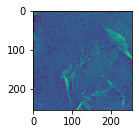

In [11]:
plt.figure(1)
plt.subplot(221)
plt.imshow(train_arr[42][:,:,0])

BUILDING THE MODEL: Encoder and Decoder

In [12]:
#BUILDING THE MODEL
#Specs for model
width_image  = train_arr.shape[1]
height_image = train_arr.shape[2]
total_channels=3 #Channels for RGB
input_shape = (height_image, width_image, total_channels)
bottle_necksize = 512 # Number of latent dim parameters
input_node_layer = Input(shape=input_shape, name='input_layer')
num_conv_layers=7

#Convolution Layers
x = Conv2D(32, 3, padding='same', activation='relu')(input_node_layer)
x = Conv2D(32, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2D(16, 3, padding='same', activation='relu')(x)
x = Conv2D(8, 3, padding='same', activation='relu')(x)
x = Conv2D(4, 3, padding='same', activation='relu')(x)
x = Conv2D(4, 3, padding='same', activation='relu')(x)
conv_shape = K.int_shape(x)
x = Flatten()(x)
x = Dense(32, activation='relu')(x)

mu = Dense(bottle_necksize, name='mu_layer')(x)   #Mean values of encoded input
sigma = Dense(bottle_necksize, name='sigma_layer')(x)  #Std dev. (variance) of encoded input
print('Conv Shape',conv_shape)

#Latent function calculation
def get_dist_sample(inputs):
    loc_mu,loc_sig=inputs
    epsilon = K.random_normal(shape=(K.shape(loc_mu)[0], K.int_shape(loc_mu)[1]))
    form=loc_mu + K.exp(loc_sig / 2) * epsilon
    return form
z_layer = Lambda(get_dist_sample, output_shape=(bottle_necksize, ), name='z_layer')([mu, sigma])
encoder_layer = Model(input_node_layer, [mu, sigma, z_layer], name='encoder_layer')
print(encoder_layer.summary())



#DECODER MODEL
decoder_input = Input(shape=(bottle_necksize, ), name='decoder_input')
x = Dense(conv_shape[1]*conv_shape[2]*conv_shape[3], activation='relu')(decoder_input)
x = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
x = Conv2DTranspose(254, 3, padding='same', activation='relu',strides=(2, 2))(x)
x = Conv2DTranspose(total_channels, 3, padding='same', activation='sigmoid', name='decoder_output')(x)

decoder = Model(decoder_input, x, name='decoder')
decoder.summary()
z_decoded = decoder(z_layer)



class Loss_Class(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        
        # Reconstruction loss (as we used sigmoid activation we can use binarycrossentropy)
        recon_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        
        # KL divergence
        kl_loss = -5e-4 * K.mean(1 + sigma - K.square(mu) - K.exp(sigma), axis=-1)
        return K.mean(recon_loss + kl_loss)

    # add custom loss to the class
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x

# apply the custom loss to the input images and the decoded latent distribution sample
y = Loss_Class()([input_node_layer, z_decoded])



vae = Model(input_node_layer, y, name='vae')

# Compile VAE
vae.compile(optimizer='adam', loss=None)
vae.summary()

# Train autoencoder
fit_model=vae.fit(train_arr, None, epochs = 10, batch_size = 60)

Conv Shape (None, 127, 127, 4)
Model: "encoder_layer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 254, 254, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 254, 254, 32  896         ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 127, 127, 32  9248        ['conv2d[0][0]']                 
                                )                      

Loss Calculation using KERAS

dict_keys(['loss'])


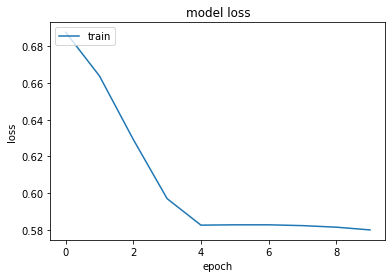

In [13]:
print(fit_model.history.keys())
plt.plot(fit_model.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


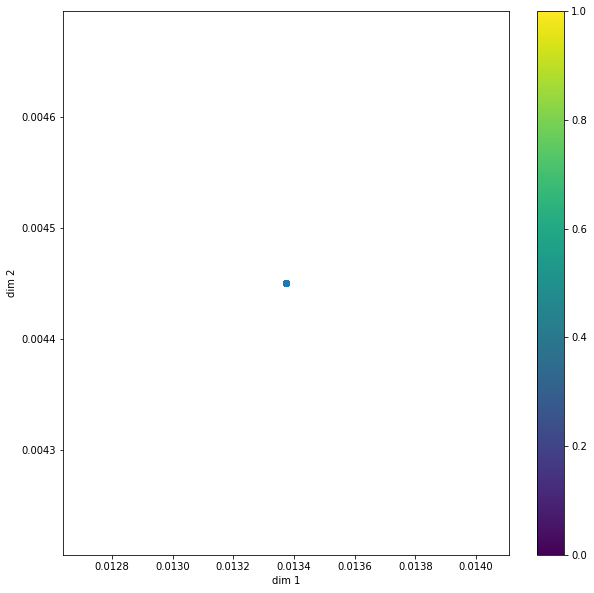

In [14]:
mu, _, _ = encoder_layer.predict(test_arr)
#Plot dim1 and dim2 for mu
plt.figure(figsize=(10, 10))
plt.scatter(mu[:, 0], mu[:, 1], cmap='brg')
plt.xlabel('dim 1')
plt.ylabel('dim 2')
plt.colorbar()
plt.show()

Computing Features for Train Set

In [19]:
mu_pred, sigma_pred, z_feature = encoder_layer.predict(train_arr)
np.shape(z_feature)

(270, 512)

In [22]:
encoder_layer.save("/content/drive/MyDrive/Quixel/autoencoder_save", overwrite=True)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/Quixel/autoencoder_save/assets


In [23]:
decoder.save("/content/drive/MyDrive/Quixel/decoder_save", overwrite=True)

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Quixel/decoder_save/assets


Calculating Feature Vectors for Train Images

In [123]:
#Feature Vectors
from keras import backend
import math
counter=0
sess = K.get_session()
dictionary_feats={}
loss_list=[]
from sklearn.metrics import log_loss
for item,train_img in zip(z_feature,train_arr):
  decoded_img = decoder.predict([[item]])
  #loss

  train_img_flat = K.flatten(train_img.astype(np.float32))
  train_flat_numpy=train_img.astype(np.float32).flatten()

  #Calculating Recon Loss
  decoded_img_flat = K.flatten(np.array(decoded_img).reshape(254,254,3))
  decoded_flat_numpy = np.array(decoded_img).reshape(254,254,3).flatten().astype(np.float32)       
  recon_loss_sklearn=log_loss(train_flat_numpy.astype(int),decoded_flat_numpy,labels=[0,1])

  # KL divergence
  kl_loss_sklearn = -5e-4 * np.mean(1 + mu_pred[counter] - np.square(mu_pred[counter]) - np.exp(sigma_pred[counter]), axis=-1)
  final_loss=np.mean(recon_loss_sklearn + kl_loss_sklearn)
  loss_list.append(final_loss)
  dictionary_feats[counter]=decoded_img
  counter+=1
final_loss_arr=np.array(loss_list)
print('Done')


Done


Evaluating Loss for Feature Vectors for Train

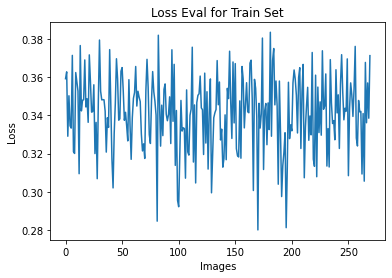

In [128]:
#Calculating Loss
plt.title('Loss Eval for Train Set')
plt.xlabel('Images')
plt.ylabel('Loss')
plt.plot(final_loss_arr)

TASK 2

In [147]:
#Task 2
#Cosine similarites for 2 crops for each image
from scipy import spatial
list_cosines=[]
for i in range (0,len(train_arr),1):
  #print(train_arr[i])
  #mu_pred, sigma_pred, z_feature = encoder_layer.predict(train_arr[i].reshape(1,254,254,3))
  lists=[]
  for x in range(0,2,1):
    mu_pred, sigma_pred, z_feature = encoder_layer.predict(train_arr[i].reshape(1,254,254,3))
    lists.append(z_feature)
    #print(len(lists))
  result = 1 - spatial.distance.cosine(lists[0], lists[1])
  #print('Cosine Similarity',result)
  list_cosines.append(result)
  



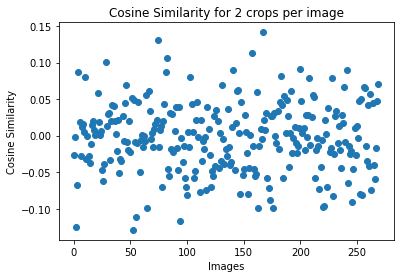

In [155]:
#Calculating Cosine Similarities
plt.title('Cosine Similarity for 2 crops per image')
plt.xlabel('Images')
plt.ylabel('Cosine Similarity')
plt.scatter(np.arange(0,len(list_cosines)),list_cosines)

In [178]:
#Task 2
#Cosine Similarities for 1 vs all cropped images
from scipy import spatial
list_cosines=[]
feats=[]
for i in range (0,len(train_arr),1):
  #print(train_arr[i])
  mu_pred, sigma_pred, z_feature = encoder_layer.predict(train_arr[i].reshape(1,254,254,3))
  feats.append(z_feature[0])

  



In [179]:
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
feats_arr = np.array(feats)
dist_out = 1-pairwise_distances(feats_arr, metric="cosine")

In [187]:
#Plotting Heathmap
import plotly.express as px
fig = px.imshow(dist_out)
fig.show()